
# Section 5: Learning from only one sample: simple siamese neural networks
## Video 1: Discussion on methods with one sample (intro dataset)

Download the dataset here: https://github.com/brendenlake/omniglot

In [1]:
import sys
import numpy as np
from scipy.misc import imread
import os
import matplotlib.pyplot as plt

data_path = "datasets/omniglot/python/"
train_path = os.path.join(data_path,'images_background')
validation_path = os.path.join(data_path,'images_evaluation')

def load_images_from_directory(path,n=0):
    X=[]
    
    ## We load every alphabet seperately and append that to one tensor
    for alphabet in os.listdir(path):
        print("loading alphabet: " + alphabet)
        alphabet_path = os.path.join(path,alphabet)
        
        ## Each character in alphabet is in a separate folder
        for letter in os.listdir(alphabet_path):
            category_images=[]
            letter_path = os.path.join(alphabet_path, letter)
      
            if not os.path.isdir(letter_path):
                continue

            ## Read every image in this directory
            for filename in os.listdir(letter_path):
                image_path = os.path.join(letter_path, filename)
                image = imread(image_path)
                category_images.append(image)
            
            try:
                X.append(np.stack(category_images))
            #edge case  - last one
            except ValueError as e:
                print(e)
                print("error - category_images:", category_images)
    
    X = np.stack(X)
    return X

print("Loading training set")
Xtrain = load_images_from_directory(train_path)
print(Xtrain.shape)

print("Now loading evaluation set")
Xval = load_images_from_directory(validation_path)
print(Xval.shape)

Loading training set
loading alphabet: Anglo-Saxon_Futhorc
loading alphabet: Mkhedruli_(Georgian)
loading alphabet: Ojibwe_(Canadian_Aboriginal_Syllabics)
loading alphabet: Braille
loading alphabet: Japanese_(hiragana)
loading alphabet: Inuktitut_(Canadian_Aboriginal_Syllabics)
loading alphabet: Asomtavruli_(Georgian)
loading alphabet: Latin
loading alphabet: Greek
loading alphabet: Japanese_(katakana)
loading alphabet: Grantha
loading alphabet: N_Ko
loading alphabet: Balinese
loading alphabet: Tagalog
loading alphabet: Bengali
loading alphabet: Blackfoot_(Canadian_Aboriginal_Syllabics)
loading alphabet: Alphabet_of_the_Magi
loading alphabet: Futurama
loading alphabet: Tifinagh
loading alphabet: Malay_(Jawi_-_Arabic)
loading alphabet: Gujarati
loading alphabet: Early_Aramaic
loading alphabet: Hebrew
loading alphabet: Syriac_(Estrangelo)
loading alphabet: Korean
loading alphabet: Arcadian
loading alphabet: Armenian
loading alphabet: Cyrillic
loading alphabet: Sanskrit
loading alphabet: 

In [2]:
import numpy.random as rng

def get_batch(data, batch_size):
    n_classes, n_examples, w, h = data.shape
    
    ## Initialise data we return in memory
    pairs=[np.zeros((batch_size, h, w,1)) for i in range(2)]
    
    ## Make a target vector with half same and half other categories
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    
    ## Pick the categories of characters we will return
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    
    for i in range(batch_size):
        category = categories[i]
        
        ## Choose two indixes from the amount of examples (20) we have
        idx_1 = rng.randint(0, n_examples)
        idx_2 = rng.randint(0, n_examples)
        
        #pick images of same class for 1st half, different for 2nd
        if targets[i] == 1:
            category_2 = category # if target is set: pick from same category
        else:
            ## Pick new class by picking random number 
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[0][i,:,:,:] = data[category,idx_1].reshape(w,h,1)
        pairs[1][i,:,:,:] = data[category_2,idx_2].reshape(w,h,1)
  
    return pairs, targets


def make_oneshot_task(data, N):
    n_val, n_ex_val, w, h = data.shape

    categories = rng.choice(n_val,size=(N,),replace=False)
    true_category = categories[0]
    
    indices = rng.randint(0, n_ex_val,size=(N,))
    
    ex1, ex2 = rng.choice(n_ex_val,replace=False,size=(2,))
    
    ## Create a list with the same image N times as test image
    test_image = np.asarray([data[true_category,ex1,:,:]]*N).reshape(N,w,h,1)
    
    support_set = data[categories,indices,:,:]
    
    ## Create the targets and fill in true character
    targets = np.zeros((N,))    
    targets[0] = 1 # Set the first target to be the true character
    support_set[0,:,:] = data[true_category,ex2] # Fill in this caracter
    
    
    ## Reshape the data and return it
    support_set = support_set.reshape(N,w,h,1)
    pairs = [test_image,support_set]
    return pairs, targets

In [3]:

class Siamese_Loader:
    """For loading batches and testing tasks to a siamese net"""
    def __init__(self,Xtrain,Xval):
        self.Xval = Xval
        self.Xtrain = Xtrain
        self.n_classes,self.n_examples,self.w,self.h = Xtrain.shape
        self.n_val,self.n_ex_val,_,_ = Xval.shape

    def get_batch(self,n):
        """Create batch of n pairs, half same class, half different class"""
        categories = rng.choice(self.n_classes,size=(n,),replace=False)
        pairs=[np.zeros((n, self.h, self.w,1)) for i in range(2)]
        targets=np.zeros((n,))
        targets[n//2:] = 1
        for i in range(n):
            category = categories[i]
            idx_1 = rng.randint(0,self.n_examples)
            pairs[0][i,:,:,:] = self.Xtrain[category,idx_1].reshape(self.w,self.h,1)
            idx_2 = rng.randint(0,self.n_examples)
            #pick images of same class for 1st half, different for 2nd
            category_2 = category if i >= n//2 else (category + rng.randint(1,self.n_classes)) % self.n_classes
            pairs[1][i,:,:,:] = self.Xtrain[category_2,idx_2].reshape(self.w,self.h,1)
        return pairs, targets

    def make_oneshot_task(self,N):
        """Create pairs of test image, support set for testing N way one-shot learning. """
        categories = rng.choice(self.n_val,size=(N,),replace=False)
        indices = rng.randint(0,self.n_ex_val,size=(N,))
        true_category = categories[0]
        ex1, ex2 = rng.choice(self.n_examples,replace=False,size=(2,))
        test_image = np.asarray([self.Xval[true_category,ex1,:,:]]*N).reshape(N,self.w,self.h,1)
        support_set = self.Xval[categories,indices,:,:]
        support_set[0,:,:] = self.Xval[true_category,ex2]
        support_set = support_set.reshape(N,self.w,self.h,1)
        pairs = [test_image,support_set]
        targets = np.zeros((N,))
        targets[0] = 1
        return pairs, targets


## Video 3: Training and testing your network. 

https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip

https://sorenbouma.github.io/blog/oneshot/

## Video 2: Defining a good loss function


2
0
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


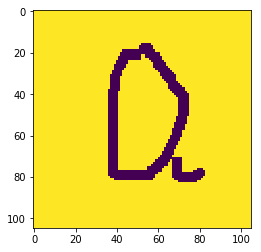

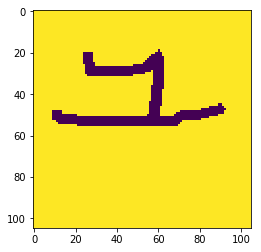

1
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


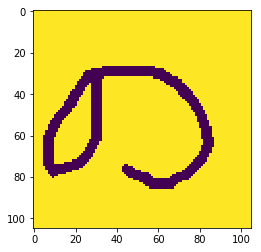

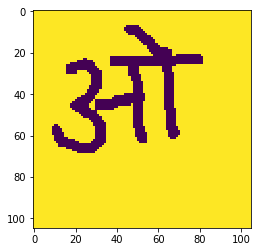

2
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


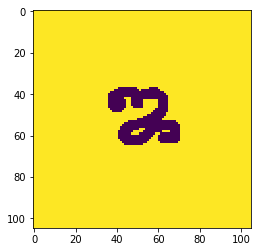

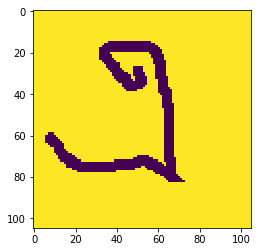

3
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


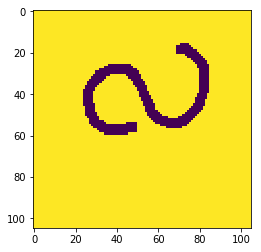

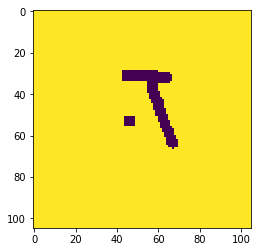

4
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


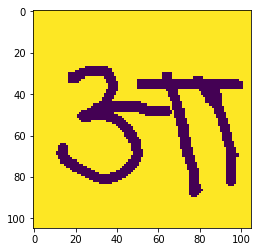

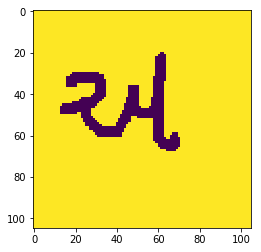

5
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


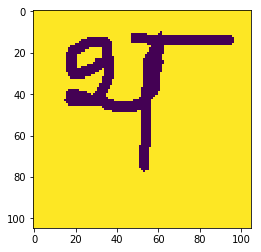

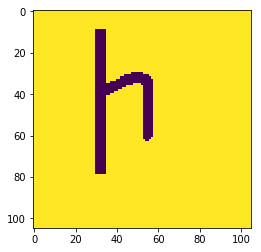

6
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


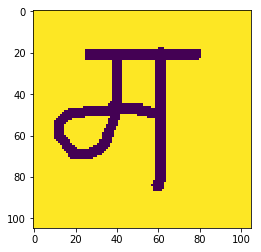

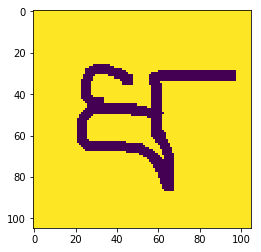

7
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


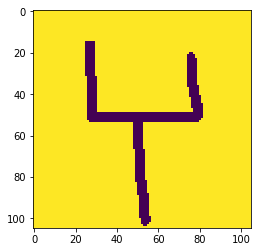

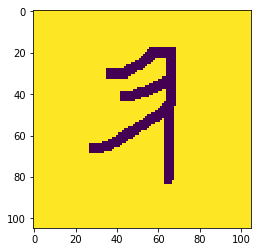

8
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


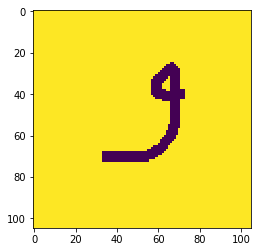

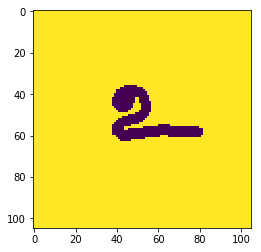

9
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


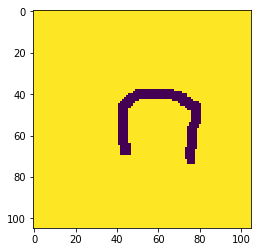

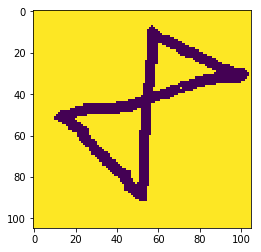

10
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


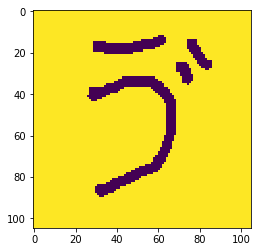

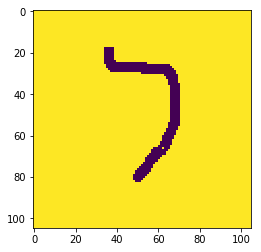

11
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


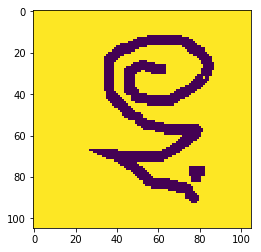

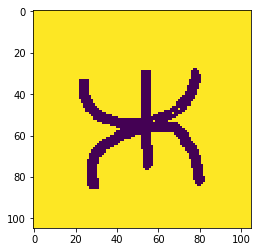

12
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


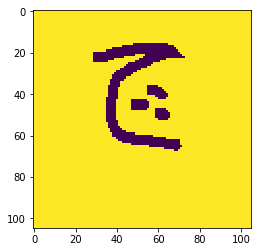

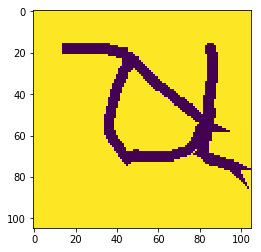

13
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


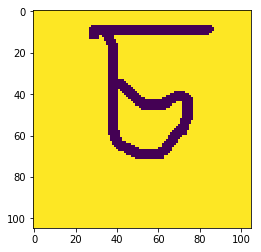

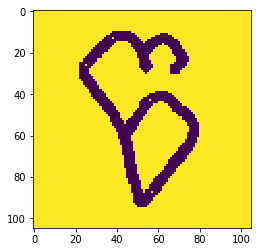

14
(105, 105, 1)
0.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


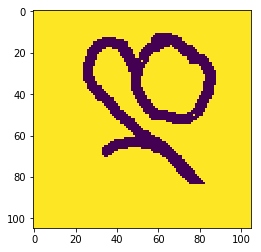

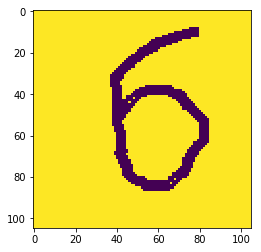

15
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


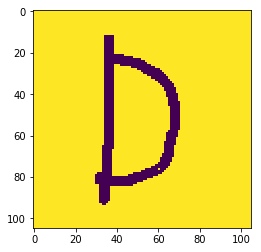

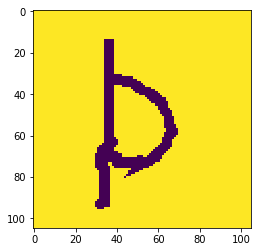

16
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


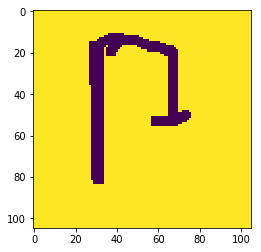

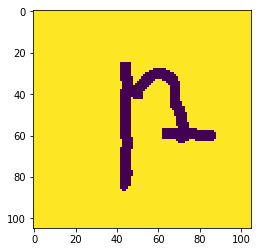

17
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


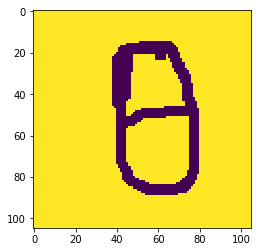

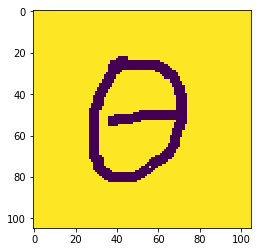

18
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


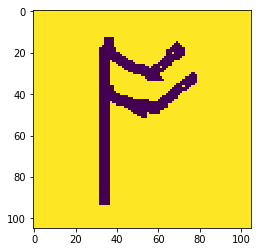

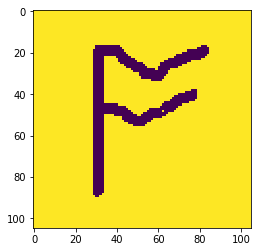

19
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


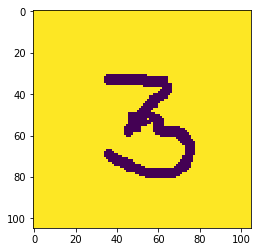

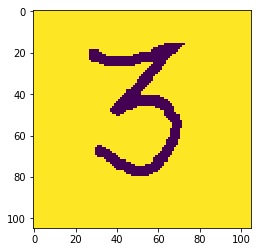

20
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


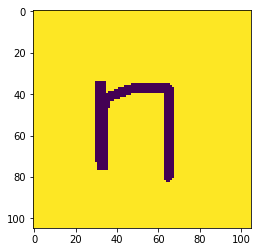

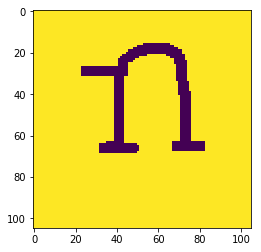

21
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


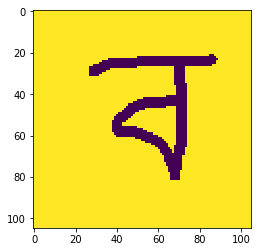

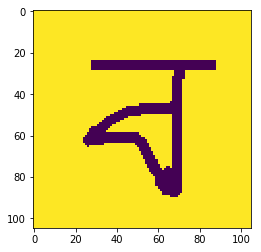

22
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


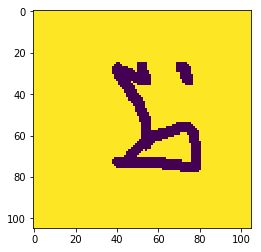

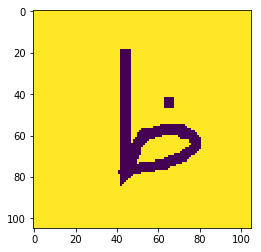

23
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


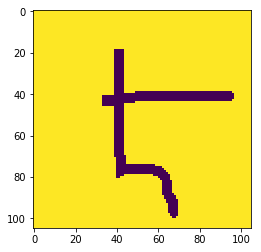

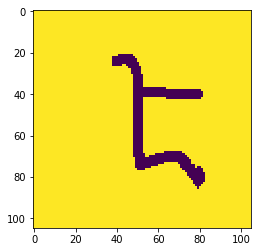

24
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


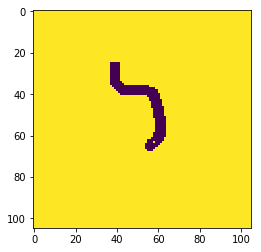

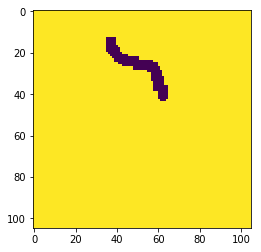

25
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


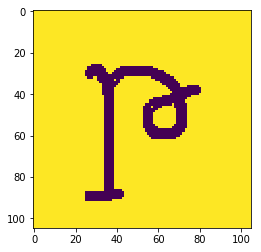

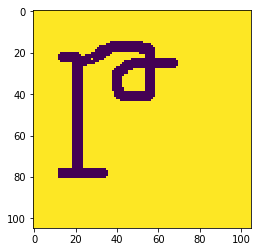

26
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


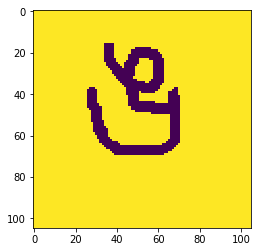

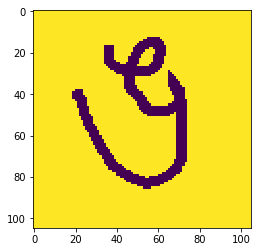

27
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


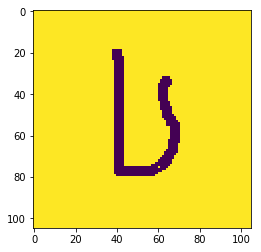

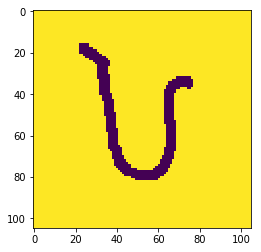

28
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


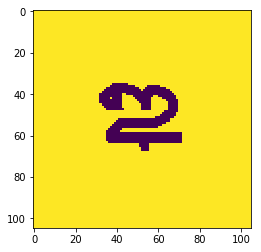

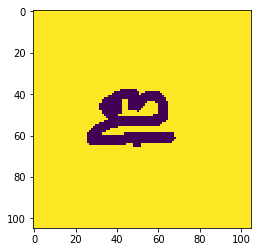

29
(105, 105, 1)
1.0
[[[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 ..., 
 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]

 [[ 255.]
  [ 255.]
  [ 255.]
  ..., 
  [ 255.]
  [ 255.]
  [ 255.]]]


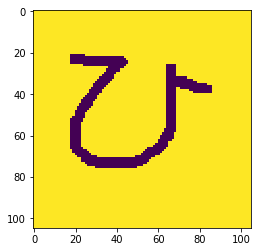

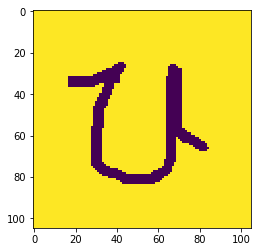

In [4]:
siam_loader = Siamese_Loader(Xtrain, Xval)
pairs, targets = siam_loader.get_batch(30)
print(len(pairs))
for i in range(len(pairs[0])):
    print(i)
    print(pairs[0][i].shape)
    print(targets[i])
    
    image = np.reshape(pairs[0][i],(105,105))
    print(pairs[0][i])
    plt.imshow(image)
    plt.show()
    image = np.reshape(pairs[1][i],(105,105))
    plt.imshow(image)
    plt.show()



In [5]:
logging_dir_n = 0

In [110]:

# prints
# [u'conv/kernel:0', u'conv/bias:0']
import numpy as np
def get_input_pipeline(x_input, reuse):
    with tf.variable_scope("first_part", reuse=reuse):
        rand_norm_std = 0.5
#         conv1 = tf.layers.conv2d(x_input, 64, [10, 10], name='conv1', activation=tf.nn.relu, padding="same")
        conv1 = tf.layers.conv2d(x_input, 64, [10, 10], name='conv1', activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        maxp1 = tf.layers.max_pooling2d(conv1, (2,2),(2,2), name='maxp1')
        
#         conv2 = tf.layers.conv2d(maxp1, 64, [7, 7], name='conv2', activation=tf.nn.relu, padding="same")
        conv2 = tf.layers.conv2d(maxp1, 64, [7, 7], name='conv2', activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        maxp2 = tf.layers.max_pooling2d(conv2, (2,2),(2,2), name='maxp2')
        
#         conv3 = tf.layers.conv2d(maxp2, 128, [4, 4], name='conv3', activation=tf.nn.relu, padding="same")
        conv3 = tf.layers.conv2d(maxp2, 128, [4, 4], name='conv3', activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        maxp3 = tf.layers.max_pooling2d(conv3, (2,2),(2,2), name='maxp3')
        #
#         conv4 = tf.layers.conv2d(maxp3, 256, [3, 3], name='conv4', activation=tf.nn.relu, padding="same")
        conv4 = tf.layers.conv2d(maxp3, 256, [3, 3], name='conv4', activation=tf.nn.relu, kernel_initializer=tf.random_normal_initializer(stddev=rand_norm_std), padding="same")
        flattened = tf.contrib.layers.flatten(conv4)
        dense1 = tf.layers.dense(flattened, 4096, activation=tf.nn.sigmoid, name="dense1")
        
    return dense1

import tensorflow as tf
tf.reset_default_graph()
image1 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1])
image2 = tf.placeholder(dtype=tf.float32, shape=[None, 105, 105, 1])
label_placeholder = tf.placeholder(dtype=tf.float32, shape=[None,1])

out_1 = get_input_pipeline(image1, None)
out_2 = get_input_pipeline(image2, True)
print([x.name for x in tf.global_variables()])

#l_one = tf.concat([out_1, out_2], axis=1)
l_one = tf.abs(tf.subtract(out_1,out_2))
#l_one_sig = tf.nn.sigmoid(l_one)

#dense_together = tf.layers.dense(l_one_sig, 1024, activation=tf.nn.relu, name="before_output")
#dense_together2 = tf.layers.dense(dense_together, 512, activation=tf.nn.relu, name="just_before_output")
prediction = tf.layers.dense(l_one, 1, activation=None, name="output")



global_step = tf.Variable(0, trainable=False)
starter_learning_rate = 0.9
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                           1, 0.99, staircase=True)

# prints
# [u'conv/kernel:0', u'conv/bias:0']



['first_part/conv1/kernel:0', 'first_part/conv1/bias:0', 'first_part/conv2/kernel:0', 'first_part/conv2/bias:0', 'first_part/conv3/kernel:0', 'first_part/conv3/bias:0', 'first_part/conv4/kernel:0', 'first_part/conv4/bias:0', 'first_part/dense1/kernel:0', 'first_part/dense1/bias:0']


In [111]:
def _to_tensor(x, dtype):
    """Convert the input `x` to a tensor of type `dtype`.
    # Arguments
        x: An object to be converted (numpy array, list, tensors).
        dtype: The destination type.
    # Returns
        A tensor.
    """
    x = tf.convert_to_tensor(x)
    if x.dtype != dtype:
        x = tf.cast(x, dtype)
    return x

def epsilon():
    return 1e-07

# def my_crossentropy(target, output):
#     # transform back to logits
#     _epsilon = _to_tensor(epsilon(), output.dtype.base_dtype)
#     output = tf.clip_by_value(output, _epsilon, 1 - _epsilon)
#     output = tf.log(output / (1 - output))

#     return tf.nn.sigmoid_cross_entropy_with_logits(labels=target,
#                                                    logits=output)

def thesis_crossentropy(label, prediction):
    print(label)
    print(prediction)
    pred1 = tf.sigmoid(prediction)
    print(pred1)
    eding = _to_tensor(epsilon(), prediction.dtype.base_dtype)
    output = tf.clip_by_value(pred1, eding, 1 - eding)
    pred1 = tf.log(output)

    a1 = tf.multiply(label, tf.log(pred1))
    print(a1)
    a2 = tf.multiply((1-label), tf.log(1-pred1))
    print(a2) 
    
    a3 = a1 + a2
    print(a3)
    return tf.reduce_mean(a3)
sigpred = tf.nn.sigmoid(prediction)

# epsilon = 0.001
# clipped_pred = tf.clip_by_value(sigpred,epsilon,1-epsilon,name="clippingtool")
# log_true = -tf.log(clipped_pred)
# log_false = -tf.log(1-clipped_pred)

# print(log_true)
# print(log_false)
# loss = tf.multiply(label_placeholder,log_true) + tf.multiply(1-label_placeholder,log_false)
# loss = tf.reduce_sum(loss)
# print(loss)

loss = tf.losses.mean_squared_error(label_placeholder,sigpred)
#loss = thesis_crossentropy(label_placeholder, prediction)
#loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=label_placeholder, logits=prediction))
# loss = my_crossentropy(label_placeholder, prediction)
#loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=label_placeholder, logits=prediction))

testloss = tf.identity(loss, name="testlossvec")
training_summary = tf.summary.scalar('loss', loss)
testing_summary = tf.summary.scalar('testloss', testloss)
merged = tf.summary.merge_all()

#w = tf.get_variable_by_name("first_part/conv1/kernel")
a = [v for v in tf.global_variables()][0]

histograms = []
for v in tf.global_variables():
    if "kernel" in v.name:
        toadd = tf.summary.histogram(v.name[:-3], v)
        histograms.append(toadd)

optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss, global_step=global_step)
#optimizer = tf.train.AdamOptimizer().minimize(loss)

In [112]:
print(label_placeholder)
print(prediction)

Tensor("Placeholder_2:0", shape=(?, 1), dtype=float32)
Tensor("output/BiasAdd:0", shape=(?, 1), dtype=float32)


In [113]:
writer = tf.summary.FileWriter(logdir='graphs/siam/'+str(logging_dir_n), graph=tf.get_default_graph())
logging_dir_n += 1
writer.flush()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
    



In [114]:
siam_loader = Siamese_Loader(Xtrain, Xval)
BATCH_SIZE = 128
for iteration in range(300):
    pairs, targets = get_batch(Xtrain, BATCH_SIZE)
    targets = [[t] for t in targets]
    _, l, summary = sess.run([optimizer, loss, training_summary], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
    print(l)
    writer.add_summary(summary, iteration)
    eval_histos = sess.run(histograms)
    for haatje in eval_histos:
        writer.add_summary(haatje, iteration)
    if iteration %10 == 0:
        pairs, targets = get_batch(Xtrain, 5)
        sp, pr = sess.run([sigpred, prediction], feed_dict={image1: pairs[0], image2: pairs[1]})
        print("sigpred:")
        print(sp)
        print("prediction")
        print(pr)
        print("targets: ")
        print(targets)
        
        pairs, targets = get_batch(Xval, BATCH_SIZE)
        targets = [[t] for t in targets]
        _, m = sess.run([testloss, testing_summary], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
        writer.add_summary(m, iteration)

0.240994
sigpred:
[[ 0.47493458]
 [ 0.43231022]
 [ 0.49299172]
 [ 0.45552343]
 [ 0.37253001]]
prediction
[[-0.10034571]
 [-0.27243173]
 [-0.02803499]
 [-0.17837784]
 [-0.52137816]]
targets: 
[ 0.  0.  1.  1.  1.]
0.251377
0.26245
0.280541
0.25122
0.250393
0.254256
0.249815
0.239631
0.234384
0.229248
sigpred:
[[ 0.34870312]
 [ 0.38852394]
 [ 0.44894129]
 [ 0.40687591]
 [ 0.38328108]]
prediction
[[-0.62474465]
 [-0.45352092]
 [-0.20494932]
 [-0.37689534]
 [-0.47564474]]
targets: 
[ 0.  0.  1.  1.  1.]
0.230345
0.236401
0.228654
0.227683
0.217811
0.227153
0.227648
0.216625
0.214455
0.221045
sigpred:
[[ 0.49495205]
 [ 0.41017532]
 [ 0.60722303]
 [ 0.45721501]
 [ 0.5229845 ]]
prediction
[[-0.02019256]
 [-0.36324066]
 [ 0.4356544 ]
 [-0.17155945]
 [ 0.09200293]]
targets: 
[ 0.  0.  1.  1.  1.]
0.223601
0.211885
0.21551
0.209143
0.217
0.201998
0.197704
0.196034
0.208128
0.209631
sigpred:
[[ 0.55791008]
 [ 0.46980506]
 [ 0.64566064]
 [ 0.51883048]
 [ 0.54215121]]
prediction
[[ 0.23268467]
 [-0

0.172902
0.17551
sigpred:
[[ 0.22261904]
 [ 0.44515583]
 [ 0.58756894]
 [ 0.52265972]
 [ 0.45716318]]
prediction
[[-1.25046861]
 [-0.22026289]
 [ 0.35392451]
 [ 0.09070098]
 [-0.17176831]]
targets: 
[ 0.  0.  1.  1.  1.]
0.174703
0.187801
0.191187
0.156971
0.164892
0.186764
0.169677
0.167612
0.167544
0.164699
sigpred:
[[ 0.57510108]
 [ 0.34720582]
 [ 0.46841317]
 [ 0.53464043]
 [ 0.6915186 ]]
prediction
[[ 0.30269444]
 [-0.6313442 ]
 [-0.12651587]
 [ 0.13878405]
 [ 0.80722845]]
targets: 
[ 0.  0.  1.  1.  1.]
0.180168
0.174247
0.176969
0.169708
0.18063
0.166527
0.172438
0.182934
0.160454


In [ ]:
## DEBUG FUCKING FUNCTIE

pairs, targets = siam_loader.get_batch(2)
newt = list()
for t in targets:
    if t == 1:
        newt.append([0,1])
    else:
        newt.append([1,0])

l, o1, o2, pred = sess.run([loss, out_1, out_2, prediction], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: newt})

print(l)
print(pred)

In [ ]:
print(pred)
print(o1)
print(o2)

In [ ]:
pairs, targets = siam_loader.get_batch(BATCH_SIZE)
targets = [[t] for t in targets]
_, l, summary = sess.run([optimizer, loss, merged], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
print(l)
writer.add_summary(summary, iteration)

In [116]:

## Determine the accuracy 
CHOOSE_FROM_N = 5
TEST_COUNT = 300

correct_tested = 0

for _ in range(TEST_COUNT):
    #inputs, targets = siam_loader.make_oneshot_task(CHOOSE_FROM_N)
    
    inputs, targets = make_oneshot_task(Xval, CHOOSE_FROM_N)
    pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
    #print(pred)
    #print(targets)
    maxindex = np.argmax(pred)

    if maxindex == 0:
        correct_tested += 1
print(correct_tested/TEST_COUNT)


0.6033333333333334


In [ ]:
pairs, targets = siam_loader.get_batch(1)
targets = [[t] for t in targets]
a1, a2 = sess.run([out_1, out_2], feed_dict={image1: pairs[0], image2: pairs[1], label_placeholder: targets})
print(a1)
print(a2)

In [ ]:
pairs, targets = siam_loader.get_batch(6)
targets = [[t] for t in targets]
pred = sess.run(prediction, feed_dict={image1: pairs[0], image2: pairs[1]})
for index in range(len(targets)):
    print(index)
    print(pred[index])
    print(targets[index])
    im = np.reshape(pairs[0][index], (105, 105))
    plt.imshow(im)
    plt.show()
    im2 = np.reshape(pairs[1][index], (105, 105))
    plt.imshow(im2)
    plt.show()
    


In [ ]:
inputs, targets = siam_loader.make_oneshot_task(5)
# print(len(inputs))
# print(len(targets))
# print(inputs[0].shape)
# print(inputs[1].shape)
# print(targets.shape)


pred = sess.run(prediction, feed_dict={image1: inputs[0], image2: inputs[1]})
print(np.argmax(pred))

# print(pred)
# print(targets)

maxindex = np.argmax(pred)
if maxindex == 0:
    print("Correct")
else:
    print("Incorrect")
im = np.reshape(inputs[0][maxindex], (105, 105))
plt.imshow(im)
plt.show()

im = np.reshape(inputs[1][maxindex], (105, 105))
plt.imshow(im)
plt.show()


# for index in range(len(targets)):
#     im = np.reshape(inputs[0][index], (105, 105))
#     plt.imshow(im)
#     plt.show()
#     im = np.reshape(inputs[1][index], (105, 105))
#     plt.imshow(im)
#     plt.show()
#     print(pred[index][0])
#     print(targets[index])
